## Setup and Imports


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import os
import pickle
from tqdm import tqdm
import nltk
from datasets import load_dataset
import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
warnings.filterwarnings("ignore")

Using device: cuda


# Task 1: Data Preparation

In [2]:
from datasets import load_dataset

ds = load_dataset("google/code_x_glue_cc_code_completion_token", "python")
ds_train = ds['train']
ds_test = ds['test']

README.md: 0.00B [00:00, ?B/s]

python/train-00000-of-00002.parquet:   0%|          | 0.00/70.1M [00:00<?, ?B/s]

python/train-00001-of-00002.parquet:   0%|          | 0.00/70.9M [00:00<?, ?B/s]

python/test-00000-of-00001.parquet:   0%|          | 0.00/69.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## 1.1 Pre-processing and Sequencing


In [3]:
class Vocabulary:
    def __init__(self, ds, vocab_size=10000):
        token_counts = Counter()
        for sample in ds:
            tokens = sample['code']
            token_counts.update(tokens)

        most_common = token_counts.most_common(vocab_size)

        self.special_tokens = {
            '<PAD>': 0,
            '<UNK>': 1,
            '<START>': 2,
            '<END>': 3
        }

        self.token_to_idx = self.special_tokens.copy()
        self.idx_to_token = {idx: token for token, idx in self.special_tokens.items()}

        # Add most frequent tokens
        for token, count in most_common:
            if token not in self.token_to_idx:
                idx = len(self.token_to_idx)
                self.token_to_idx[token] = idx
                self.idx_to_token[idx] = token

        self.vocab_size = len(self.token_to_idx)
        self.unk_idx = self.special_tokens['<UNK>']
        self.pad_idx = self.special_tokens['<PAD>']
        self.start_idx = self.special_tokens['<START>']
        self.end_idx = self.special_tokens['<END>']

        print(f"Vocabulary size: {self.vocab_size}")

    def encode(self, sequence):
        return [self.token_to_idx.get(token, self.unk_idx) for token in sequence]

    def decode(self, indices):
        return [self.idx_to_token.get(idx, '<UNK>') for idx in indices]

vocab = Vocabulary(ds_train, vocab_size=10000)
print(f"Vocabulary created with {vocab.vocab_size} tokens")


Vocabulary size: 10004
Vocabulary created with 10004 tokens


## 1.2 Dataset Loader and Data Splitting


In [ ]:
class CodeCompletionDataset(Dataset):
    def __init__(self, ds, vocab, max_length=1000):
        self.sequences = ds
        self.vocab = vocab
        self.max_length = max_length

        self.encoded_sequences = []
        for seq in ds:
            encoded = vocab.encode(seq['code'])
            if len(encoded) > max_length:
                encoded = encoded[:max_length]
            else:
                encoded = encoded + [vocab.pad_idx] * (max_length - len(encoded))
            self.encoded_sequences.append(encoded)
 
    def __len__(self):
        return len(self.encoded_sequences)

    def __getitem__(self, idx):
        sequence = self.encoded_sequences[idx]
        input_seq = torch.tensor(sequence[:-1], dtype=torch.long)
        target_seq = torch.tensor(sequence[1:], dtype=torch.long)
        return input_seq, target_seq

np.random.seed(42)
indices = np.random.permutation(len(ds_train))
split_idx = int(0.8 * len(ds_train))

train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

train_split = [ds_train[int(i)] for i in train_indices]
val_split = [ds_train[int(i)] for i in val_indices]

print(f"Training split: {len(train_split)} sequences")
print(f"Validation split: {len(val_split)} sequences")
print(f"Test split: {len(ds_test)} sequences")

train_dataset = CodeCompletionDataset(train_split, vocab, max_length=1000)
val_dataset = CodeCompletionDataset(val_split, vocab, max_length=1000)
test_dataset = CodeCompletionDataset(ds_test, vocab, max_length=1000)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Data loaders created with batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training split: 80000 sequences
Validation split: 20000 sequences
Test split: 50000 sequences
Data loaders created with batch size: 64
Training batches: 1250
Validation batches: 313
Test batches: 782


# Task 2: Baseline Models - Comparison



## 2.1 Model Implementation

In [5]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2, dropout=0.3):
        super(RNNModel, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer (trainable from scratch)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            nonlinearity='tanh'
        )

        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
        rnn_output, hidden = self.rnn(embedded, hidden)
        rnn_output = self.dropout(rnn_output)
        output = self.output_layer(rnn_output)

        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer (trainable from scratch)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)


        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
        lstm_output, hidden = self.lstm(embedded, hidden)
        lstm_output = self.dropout(lstm_output)
        output = self.output_layer(lstm_output)

        return output, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

rnn_model = RNNModel(vocab.vocab_size).to(device)
lstm_model = LSTMModel(vocab.vocab_size).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

rnn_params = count_parameters(rnn_model)
lstm_params = count_parameters(lstm_model)

print(f"RNN Model Parameters: {rnn_params:,}")
print(f"LSTM Model Parameters: {lstm_params:,}")
print(f"RNN Model Architecture:")
print(rnn_model)
print(f"\nLSTM Model Architecture:")
print(lstm_model)

RNN Model Parameters: 8,612,628
LSTM Model Parameters: 11,371,284
RNN Model Architecture:
RNNModel(
  (embedding): Embedding(10004, 256)
  (rnn): RNN(256, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=512, out_features=10004, bias=True)
)

LSTM Model Architecture:
LSTMModel(
  (embedding): Embedding(10004, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=512, out_features=10004, bias=True)
)


## 2.2 Training & Validation



In [6]:
def calculate_top5_accuracy(predictions, targets, pad_idx):
    top5_preds = torch.topk(predictions, k=5, dim=-1).indices

    mask = (targets != pad_idx)

    correct = torch.zeros_like(targets, dtype=torch.bool)
    for i in range(5):
        correct |= (top5_preds[:, :, i] == targets)

    masked_correct = correct & mask
    masked_total = mask.sum()

    if masked_total == 0:
        return 0.0

    return masked_correct.sum().float() / masked_total.float()

def calculate_perplexity(loss):
    return torch.exp(loss)

def train_epoch(model, train_loader, device, optimizer, criterion, pad_idx):
    model.train()
    total_loss = 0
    num_batches = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc="Training")):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches

    return avg_loss

def validate_epoch(model, val_loader, device, criterion, pad_idx):
    model.eval()
    total_loss = 0
    total_top5_acc = 0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Validation"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            top5_acc = calculate_top5_accuracy(outputs, targets, pad_idx)
            total_top5_acc += top5_acc.item()

            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    avg_top5_acc = total_top5_acc / num_batches
    avg_ppl = calculate_perplexity(torch.tensor(avg_loss))

    return avg_loss, avg_top5_acc, avg_ppl.item()

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, device=device, pad_idx=0):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    train_losses = []
    val_losses = []
    val_top5_accs = []
    val_ppls = []

    best_val_loss = float('inf')
    best_model_state = None
    patience = 3
    patience_counter = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_loss= train_epoch(model, train_loader, device, optimizer, criterion, pad_idx)
        val_loss, val_top5, val_ppl = validate_epoch(model, val_loader, device, criterion, pad_idx)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_top5_accs.append(val_top5)
        val_ppls.append(val_ppl)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Top-5 Acc: {val_top5:.4f}, Val PPL: {val_ppl:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    model_name = model.__class__.__name__.lower()
    save_path = f'{model_name}_trained.pt'
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_top5_accs': val_top5_accs,
        'val_ppls': val_ppls
    }


In [8]:
print("=" * 50)
print("Training RNN Model")
print("=" * 50)

rnn_history = train_model(rnn_model, train_loader, val_loader, epochs=5, lr=0.001, pad_idx=vocab.pad_idx)

Training RNN Model

Epoch 1/5


Validation: 100%|██████████| 313/313 [01:53<00:00,  2.76it/s]


Train Loss: 2.4405
Val Loss: 2.0710, Val Top-5 Acc: 0.8059, Val PPL: 7.9328

Epoch 2/5


Validation: 100%|██████████| 313/313 [01:55<00:00,  2.72it/s]


Train Loss: 2.0709
Val Loss: 2.0530, Val Top-5 Acc: 0.8103, Val PPL: 7.7916

Epoch 3/5


Validation: 100%|██████████| 313/313 [01:53<00:00,  2.75it/s]


Train Loss: 2.0209
Val Loss: 1.8934, Val Top-5 Acc: 0.8247, Val PPL: 6.6422

Epoch 4/5


Validation: 100%|██████████| 313/313 [01:53<00:00,  2.75it/s]


Train Loss: 1.9434
Val Loss: 1.8579, Val Top-5 Acc: 0.8288, Val PPL: 6.4099

Epoch 5/5


Validation: 100%|██████████| 313/313 [01:53<00:00,  2.76it/s]


Train Loss: 1.9205
Val Loss: 1.8290, Val Top-5 Acc: 0.8316, Val PPL: 6.2276
Model saved to rnnmodel_trained.pt


In [7]:
print("=" * 50)
print("Training LSTM Model")
print("=" * 50)

lstm_history = train_model(lstm_model, train_loader, val_loader, epochs=5, lr=0.001, pad_idx=vocab.pad_idx)

Training LSTM Model

Epoch 1/5


Validation: 100%|██████████| 313/313 [02:39<00:00,  1.97it/s]


Train Loss: 3.0655
Val Loss: 2.2987, Val Top-5 Acc: 0.7807, Val PPL: 9.9611

Epoch 2/5


Validation: 100%|██████████| 313/313 [02:38<00:00,  1.98it/s]


Train Loss: 2.1574
Val Loss: 1.9563, Val Top-5 Acc: 0.8172, Val PPL: 7.0732

Epoch 3/5


Validation: 100%|██████████| 313/313 [02:37<00:00,  1.98it/s]


Train Loss: 1.9294
Val Loss: 1.8017, Val Top-5 Acc: 0.8341, Val PPL: 6.0600

Epoch 4/5


Validation: 100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


Train Loss: 1.7982
Val Loss: 1.6992, Val Top-5 Acc: 0.8457, Val PPL: 5.4696

Epoch 5/5


Validation: 100%|██████████| 313/313 [02:37<00:00,  1.99it/s]

Train Loss: 1.7069
Val Loss: 1.6259, Val Top-5 Acc: 0.8541, Val PPL: 5.0831
Model saved to lstmmodel_trained.pt


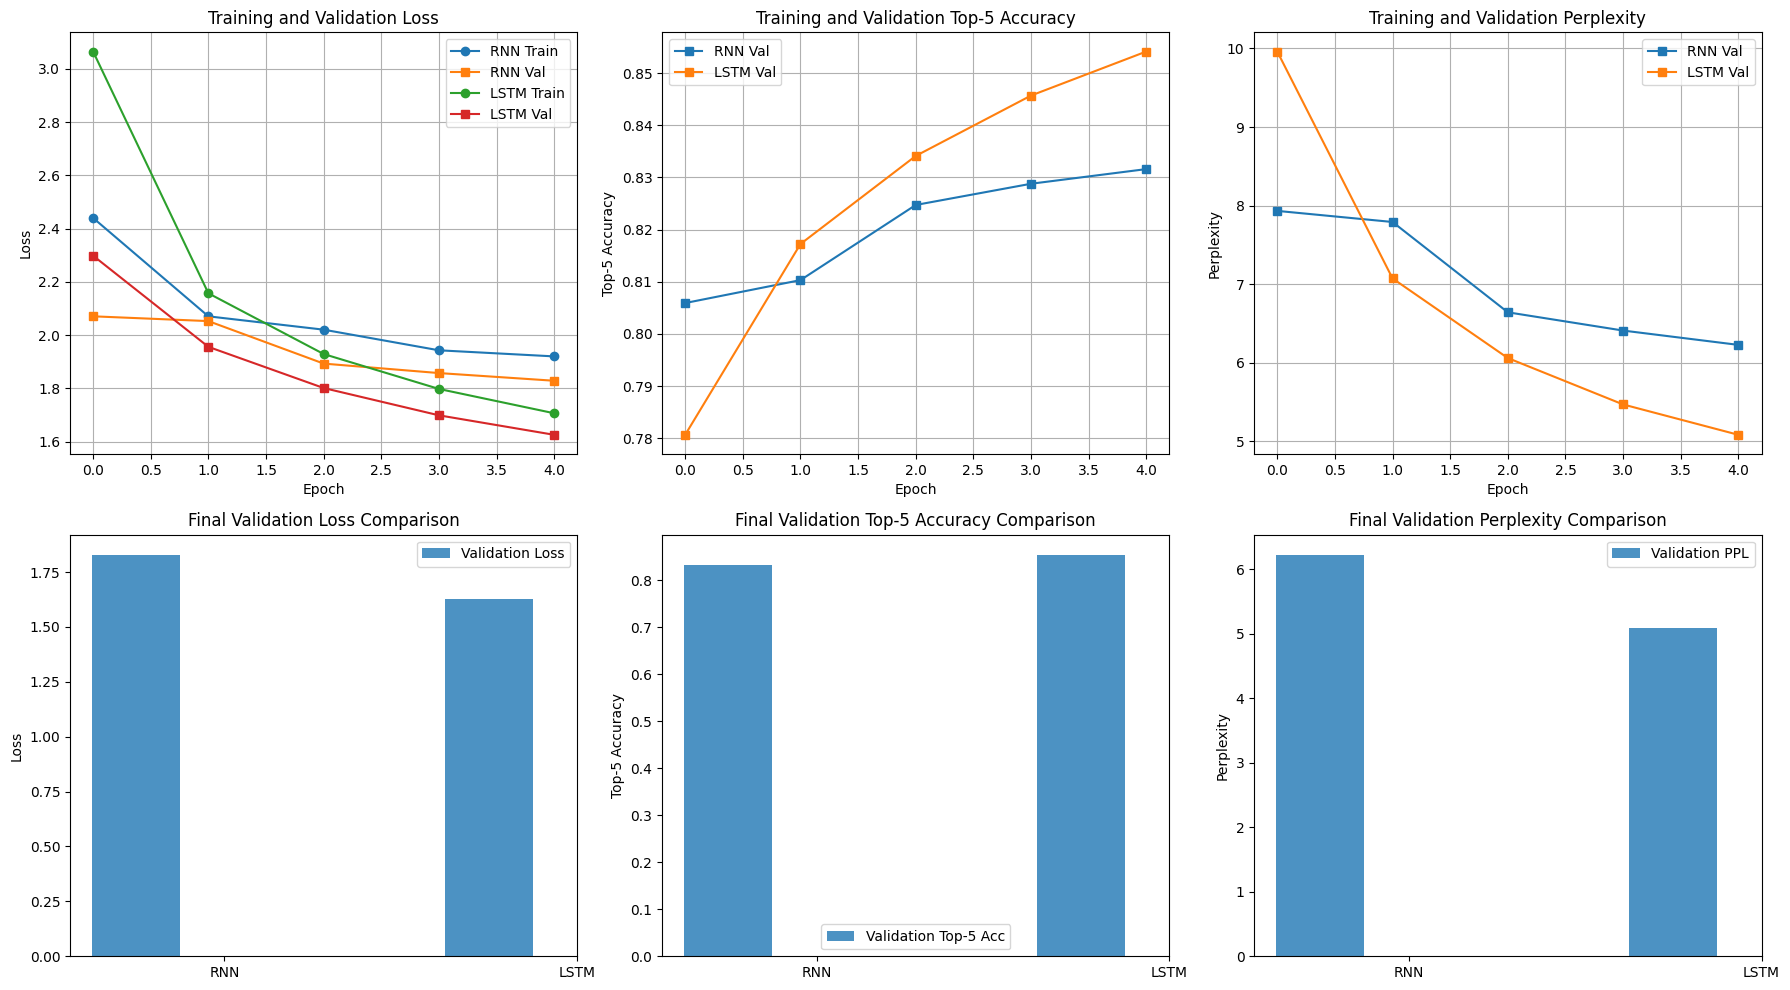


FINAL VALIDATION RESULTS
RNN - Val Loss: 1.8290, Val Top-5 Acc: 0.8316, Val PPL: 6.2276
LSTM - Val Loss: 1.6259, Val Top-5 Acc: 0.8541, Val PPL: 5.0831


In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(rnn_history['train_losses'], label='RNN Train', marker='o')
axes[0, 0].plot(rnn_history['val_losses'], label='RNN Val', marker='s')
axes[0, 0].plot(lstm_history['train_losses'], label='LSTM Train', marker='o')
axes[0, 0].plot(lstm_history['val_losses'], label='LSTM Val', marker='s')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(rnn_history['val_top5_accs'], label='RNN Val', marker='s')
axes[0, 1].plot(lstm_history['val_top5_accs'], label='LSTM Val', marker='s')
axes[0, 1].set_title('Training and Validation Top-5 Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Top-5 Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[0, 2].plot(rnn_history['val_ppls'], label='RNN Val', marker='s')
axes[0, 2].plot(lstm_history['val_ppls'], label='LSTM Val', marker='s')
axes[0, 2].set_title('Training and Validation Perplexity')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Perplexity')
axes[0, 2].legend()
axes[0, 2].grid(True)

models = ['RNN', 'LSTM']
val_losses = [rnn_history['val_losses'][-1], lstm_history['val_losses'][-1]]
val_top5_accs = [rnn_history['val_top5_accs'][-1], lstm_history['val_top5_accs'][-1]]
val_ppls = [rnn_history['val_ppls'][-1], lstm_history['val_ppls'][-1]]

x = np.arange(len(models))
width = 0.25

axes[1, 0].bar(x - width, val_losses, width, label='Validation Loss', alpha=0.8)
axes[1, 0].set_title('Final Validation Loss Comparison')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].legend()

axes[1, 1].bar(x - width, val_top5_accs, width, label='Validation Top-5 Acc', alpha=0.8)
axes[1, 1].set_title('Final Validation Top-5 Accuracy Comparison')
axes[1, 1].set_ylabel('Top-5 Accuracy')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend()

axes[1, 2].bar(x - width, val_ppls, width, label='Validation PPL', alpha=0.8)
axes[1, 2].set_title('Final Validation Perplexity Comparison')
axes[1, 2].set_ylabel('Perplexity')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(models)
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("FINAL VALIDATION RESULTS")
print("=" * 60)
print(f"RNN - Val Loss: {rnn_history['val_losses'][-1]:.4f}, Val Top-5 Acc: {rnn_history['val_top5_accs'][-1]:.4f}, Val PPL: {rnn_history['val_ppls'][-1]:.4f}")
print(f"LSTM - Val Loss: {lstm_history['val_losses'][-1]:.4f}, Val Top-5 Acc: {lstm_history['val_top5_accs'][-1]:.4f}, Val PPL: {lstm_history['val_ppls'][-1]:.4f}")

## 2.3 Final Evaluation & Reporting



In [11]:
def evaluate_model(model, test_loader, device, pad_idx):
    """
    Evaluate model on test set
    """
    model.eval()
    total_loss = 0
    total_top5_acc = 0
    num_batches = 0

    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            top5_acc = calculate_top5_accuracy(outputs, targets, pad_idx)
            total_top5_acc += top5_acc.item()

            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    avg_top5_acc = total_top5_acc / num_batches
    avg_ppl = calculate_perplexity(torch.tensor(avg_loss))

    return avg_loss, avg_top5_acc, avg_ppl.item()

print("=" * 60)
print("FINAL TEST EVALUATION")
print("=" * 60)

print("Evaluating RNN model on test set...")
rnn_test_loss, rnn_test_top5, rnn_test_ppl = evaluate_model(rnn_model, test_loader, device, vocab.pad_idx)

print("Evaluating LSTM model on test set...")
lstm_test_loss, lstm_test_top5, lstm_test_ppl = evaluate_model(lstm_model, test_loader, device, vocab.pad_idx)

print("\n" + "=" * 60)
print("FINAL TEST RESULTS")
print("=" * 60)
print(f"RNN - Test Loss: {rnn_test_loss:.4f}, Test Top-5 Acc: {rnn_test_top5:.4f}, Test PPL: {rnn_test_ppl:.4f}")
print(f"LSTM - Test Loss: {lstm_test_loss:.4f}, Test Top-5 Acc: {lstm_test_top5:.4f}, Test PPL: {lstm_test_ppl:.4f}")

if rnn_test_top5 > lstm_test_top5:
    best_test_model = 'RNN'
    best_test_model_obj = rnn_model
    best_test_top5 = rnn_test_top5
    best_test_ppl = rnn_test_ppl
    best_test_params = rnn_params
else:
    best_test_model = 'LSTM'
    best_test_model_obj = lstm_model
    best_test_top5 = lstm_test_top5
    best_test_ppl = lstm_test_ppl
    best_test_params = lstm_params

print(f"\nBest performing model on test set: {best_test_model}")
print(f"Test Top-5 Accuracy: {best_test_top5:.4f}")
print(f"Test Perplexity: {best_test_ppl:.4f}")
print(f"Total Parameters: {best_test_params:,}")

FINAL TEST EVALUATION
Evaluating RNN model on test set...


Testing: 100%|██████████| 782/782 [04:45<00:00,  2.74it/s]


Evaluating LSTM model on test set...


Testing: 100%|██████████| 782/782 [06:34<00:00,  1.98it/s]


FINAL TEST RESULTS
RNN - Test Loss: 1.7434, Test Top-5 Acc: 0.8401, Test PPL: 5.7166
LSTM - Test Loss: 1.5485, Test Top-5 Acc: 0.8614, Test PPL: 4.7045

Best performing model on test set: LSTM
Test Top-5 Accuracy: 0.8614
Test Perplexity: 4.7045
Total Parameters: 11,371,284


# Task 3: Residual Recurrent Models

## 3.1 Implementation



In [13]:
class ResidualLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2, dropout=0.3):
        super(ResidualLSTMModel, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.lstm2 = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)

        self.output_layer = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden1=None, hidden2=None):

        embedded = self.embedding(x)
        h1, hidden1 = self.lstm1(embedded, hidden1)
        h1_dropout = self.dropout(h1)
        h2, hidden2 = self.lstm2(h1_dropout, hidden2)
        h_final = h1 + h2
        h_final = self.dropout(h_final)
        output = self.output_layer(h_final)
        return output, (hidden1, hidden2)

    def init_hidden(self, batch_size):
        h1_0 = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        c1_0 = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        h2_0 = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        c2_0 = torch.zeros(1, batch_size, self.hidden_dim).to(device)
        return ((h1_0, c1_0), (h2_0, c2_0))

residual_model = ResidualLSTMModel(vocab.vocab_size).to(device)
print("Created Residual LSTM Model")

residual_params = count_parameters(residual_model)
print(f"Residual Model Parameters: {residual_params:,}")


Created Residual LSTM Model
Residual Model Parameters: 11,371,284


## 3.2 Training



In [14]:
print("=" * 50)
print("Training Residual Model")
print("=" * 50)

residual_history = train_model(residual_model, train_loader, val_loader, epochs=5, lr=0.001, device=device, pad_idx=vocab.pad_idx)


Training Residual Model

Epoch 1/5


Validation: 100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


Train Loss: 2.3036
Val Loss: 1.8545, Val Top-5 Acc: 0.8311, Val PPL: 6.3885

Epoch 2/5


Validation: 100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


Train Loss: 1.7748
Val Loss: 1.6287, Val Top-5 Acc: 0.8565, Val PPL: 5.0973

Epoch 3/5


Validation: 100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


Train Loss: 1.6044
Val Loss: 1.5148, Val Top-5 Acc: 0.8689, Val PPL: 4.5487

Epoch 4/5


Validation: 100%|██████████| 313/313 [02:39<00:00,  1.97it/s]


Train Loss: 1.5051
Val Loss: 1.4451, Val Top-5 Acc: 0.8769, Val PPL: 4.2424

Epoch 5/5


Validation: 100%|██████████| 313/313 [02:39<00:00,  1.96it/s]

Train Loss: 1.4387
Val Loss: 1.3998, Val Top-5 Acc: 0.8820, Val PPL: 4.0544
Model saved to residuallstmmodel_trained.pt


Store the entire model object

In [16]:
save_path = 'residual_trained.pt'
torch.save(residual_model, save_path)
print(f"Model saved to {save_path}")

Model saved to residual_trained.pt


## 3.3 Evaluation and Reporting

Evaluating the trained residual model on the test set and compare with the best baseline model.


In [15]:
print("Evaluating Residual model on test set...")
residual_test_loss, residual_test_top5, residual_test_ppl = evaluate_model(residual_model, test_loader, device, vocab.pad_idx)

print("\n" + "=" * 60)
print("RESIDUAL CONNECTION RESULTS")
print("=" * 60)
print(f"Best Baseline ({best_test_model}) - Test Top-5 Acc: {best_test_top5:.4f}, Test PPL: {best_test_ppl:.4f}")
print(f"Residual Model - Test Top-5 Acc: {residual_test_top5:.4f}, Test PPL: {residual_test_ppl:.4f}")


comparison_df = pd.DataFrame({
    'Model': [f'Baseline {best_test_model}', 'Residual Model'],
    'Test Top-5 Accuracy': [best_test_top5, residual_test_top5],
    'Test Perplexity': [best_test_ppl, residual_test_ppl],
    'Total Parameters': [best_test_params, residual_params]
})

print("\n" + "=" * 60)
print("RESIDUAL CONNECTION COMPARISON")
print("=" * 60)
print(comparison_df.to_string(index=False))



Evaluating Residual model on test set...


Testing: 100%|██████████| 782/782 [06:38<00:00,  1.96it/s]


RESIDUAL CONNECTION RESULTS
Best Baseline (LSTM) - Test Top-5 Acc: 0.8614, Test PPL: 4.7045
Residual Model - Test Top-5 Acc: 0.8880, Test PPL: 3.7908

RESIDUAL CONNECTION COMPARISON
         Model  Test Top-5 Accuracy  Test Perplexity  Total Parameters
 Baseline LSTM             0.861420         4.704540          11371284
Residual Model             0.888023         3.790807          11371284
